# Clase 11 - DBSCAN

## Carga de librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [12, 12]
np.random.seed(42)

#MAKEBLOBS ES UNA FUNCION
#UNA FUNCION PARA HACER SIMULACIONES
#SIRVE PARA CREAR CLUSTERS DE N DIMENSIONES
from sklearn.datasets import make_blobs

#SE IMPORTAN LAS LIBRERIAS DE KMEANS Y DBSCAN
#SE IMPORTA LAS LIBERIAS PARA LAS METRICAS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

## Ejercicio

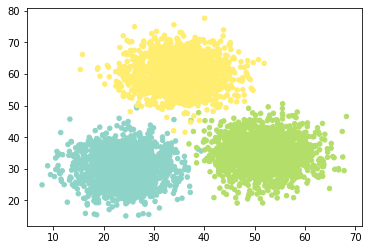

In [3]:
#SE HACEN TRES ESFERAS
n_muestras = 5000

centroides = [(24, 30), (52, 35), (35, 60)]
X, clases_reales = make_blobs(n_samples=n_muestras, n_features=2, cluster_std=5.0,
                  centers=centroides, shuffle=False, random_state=42)



#SE IMPRIMEN LOS CLUSTERS SIMULADOS MEDIANTE BLOBS
from matplotlib  import cm
plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3);

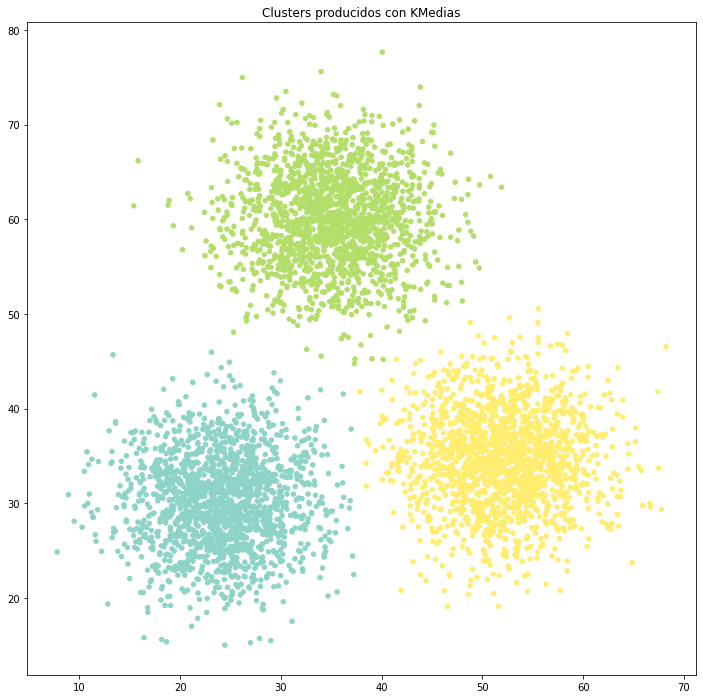

In [5]:
#SE APLICA KMEDIAS PARA LOS DATOS SIMULADOS PARA TRES CLUSTERS
estimador_kmedias = KMeans(n_clusters=3)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

#SE IMPRIME LOS CLUSTERS OBTENIDOS POR KMEANS
plt.figure()
plt.scatter(X[:,0],X[:,1], c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias");

Dado que en este ejemplo, tenemos las clases verdaderas (ya que hemos generado el dataset de forma artificial), vamos a hacer unas funciones auxiliares que nos ayuden a mostrar de forma clara aquellos puntos que se clasifican de forma incorrecta.

En primer lugar, creamos una función que nos calcule el Índice de Jaccard de dos grupos de puntos (definido como el número de elementos comunes a los dos grupos (intersección) de los dos grupos dividida por el número de elementos en cualquiera de los dos grupos (la unión).

In [6]:
#FUNCION PARA OBTENER EL INDICE DE JACCARD
def jaccard_index(cluster1, cluster2):
    intersection = np.intersect1d(cluster1, cluster2).shape[0]
    union = np.union1d(cluster1, cluster2).shape[0]
    return intersection / union

In [9]:
#SE OBTIENE EL INDICE DE JACCARD PERO HAY QUE TENER CUIDADO CON LAS CLASES REALES Y LAS CLASES CALCULADAS
print("Indice de Jaccard")
print(jaccard_index(X[clases_reales==0], X[etiquetas_kmedias==0]))

Indice de Jaccard
0.9952095808383233


Ahora hacemos una funcion, que dado un conjunto de clases y clusters, nos diga que cluster se corresponde a cada clase. Esto es necesario ya que los nombres que da el estimador de clustering no tienen por qué coincidir con las clases reales (es decir, la clase 0 no tiene que representar al mismo número de puntos que el cluster 0).

Emparejamiento de clases

In [10]:
from itertools import product

#SE FORMAN TODAS LAS PAREJAS POSIBLES
list(product([1,2],[3,4]))

#PRODUCTO CARTESIANO Y APLICA EL INDICE JACCARD
def emparejar_clusters_clases(clusters, clases):
    combinaciones = product(np.unique(clases), np.unique(clusters))
    emparejamientos = {}
    class_ids = np.unique(clases)
    cluster_ids = np.unique(clusters)
    for cluster_id in cluster_ids:
        old_jaccard = 0
        for class_id in class_ids:
            new_jaccard = jaccard_index(X[clases==class_id], X[clusters==cluster_id])
            if new_jaccard > old_jaccard:
                old_jaccard = new_jaccard
                emparejamientos[cluster_id] = class_id
                if new_jaccard>=0.5:
                    break
    return emparejamientos

In [11]:
#SE HACE EL EMPAREJAMIENTO DE LOS CLUSTERS
print(emparejar_clusters_clases(etiquetas_kmedias, clases_reales))


{0: 0, 1: 2, 2: 1}


In [12]:
# Con estas funciones podemos crear una función auxiliar que nos transforma unas etiquetas 
# de cluster para que se correspondan con las clases reales, y una función que nos devuelva 
# aquellas observaciones cuya clase no coincida con el cluster
def alinear_clusters(clusters, clases):
    reemplazos = emparejar_clusters_clases(clusters, clases)
    clusters_alineados = [reemplazos[x] for x in clusters]
    return np.array(clusters_alineados)

def encontrar_errores(clusters, clases):
    etiquetas_clusters_alineadas = alinear_clusters(clusters, clases)
    return X[clases!=etiquetas_clusters_alineadas]

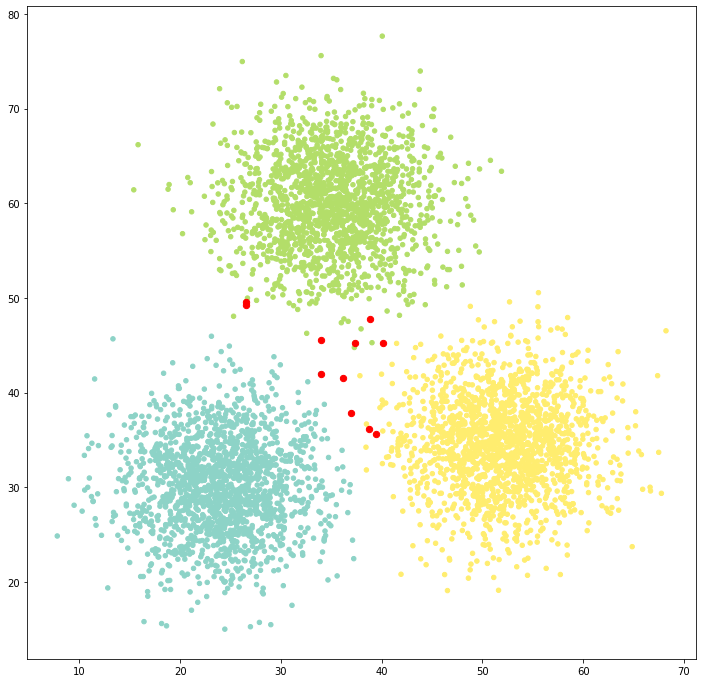

In [13]:
#SE OBTIENEN LOS VALORES ANOMALAS
#Ahora podemos visualizar los puntos mal agrupados
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")

**DBSCAN**

In [14]:
#SE UTILIZA LA CLASIFICACION DBSCAN
estimador_dbscan = DBSCAN(eps=10, min_samples=1000)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

print(np.unique(etiquetas_dbscan))

[-1  0  1  2]


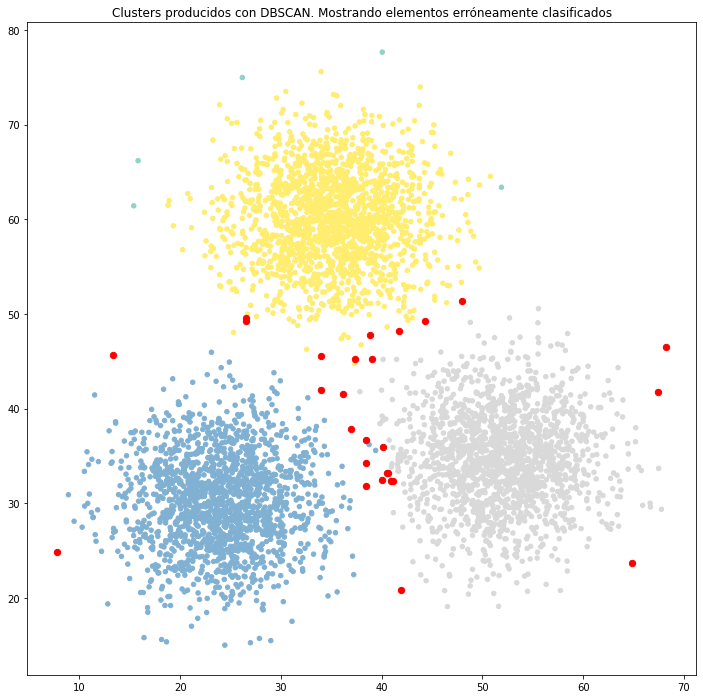

In [15]:
#SE OBTIENE LA GRAFICA DE LOS PUNTOS QUE NO PUDO CLASIFICAR
plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")
plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

In [16]:
#SE IMPRIMEN LAS METRICAS
print("Metricas con DBSCAN")
print("Silueta: ",silhouette_score(X, etiquetas_dbscan))
print(homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan))

Metricas con DBSCAN
Silueta:  0.6723834492118366
(0.9720560210205188, 0.9604880908580997, 0.9662374339590347)


Vemos que para el caso de tres clusters claramente definidos, KMedias funciona ligeramente mejor que DBSCAN

Probamos ahora con una distribución de datos que no sean tan fáciles de separar en grupos basándose en criterios geométricos.

## Ejemplo 2

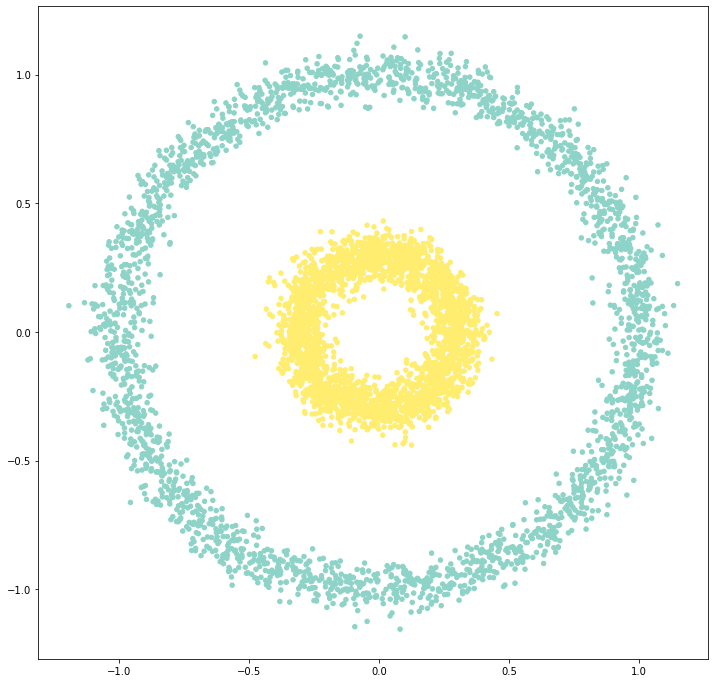

In [17]:
from sklearn.datasets import make_circles
#SE GENERA DOS NUBES DE PUNTOS
X, clases_reales = make_circles(n_samples=5000, factor=.3, noise=.05)
#SE OBTIENEN LAS GRAFICAS DE LAS NUBES DE PUNTOS
plt.figure()
plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3);

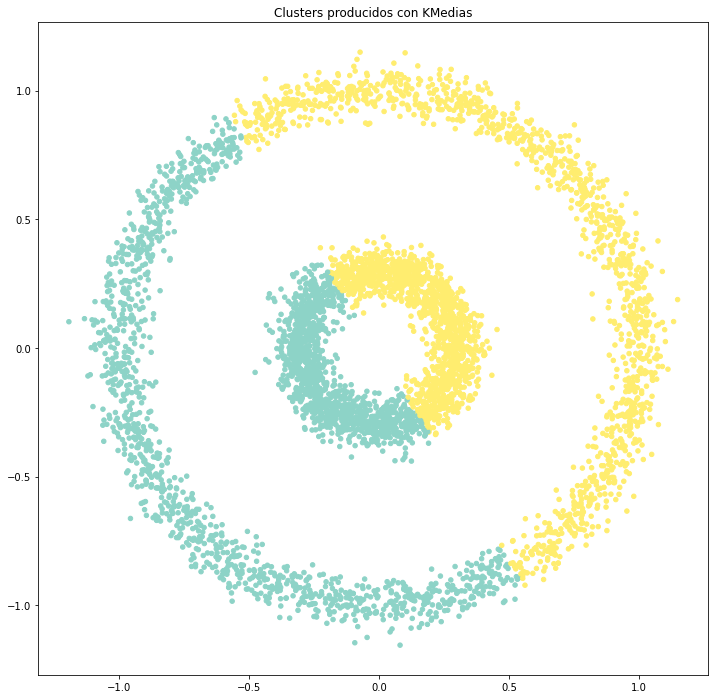

In [18]:
#SE UTILIZA KMEDIAS PARA LOS CLUSTERS
estimador_kmedias = KMeans(n_clusters=2)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_
#SE GRAFICA LA CLASIFICACION
plt.figure()
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias");

Vemos que al basarse en el criterio de cercania al centroide, y dado que ambos clases tienen el mismo centroide, el algoritmo KMedias funciona de forma bastante mediocre, por no decir catastrófica.

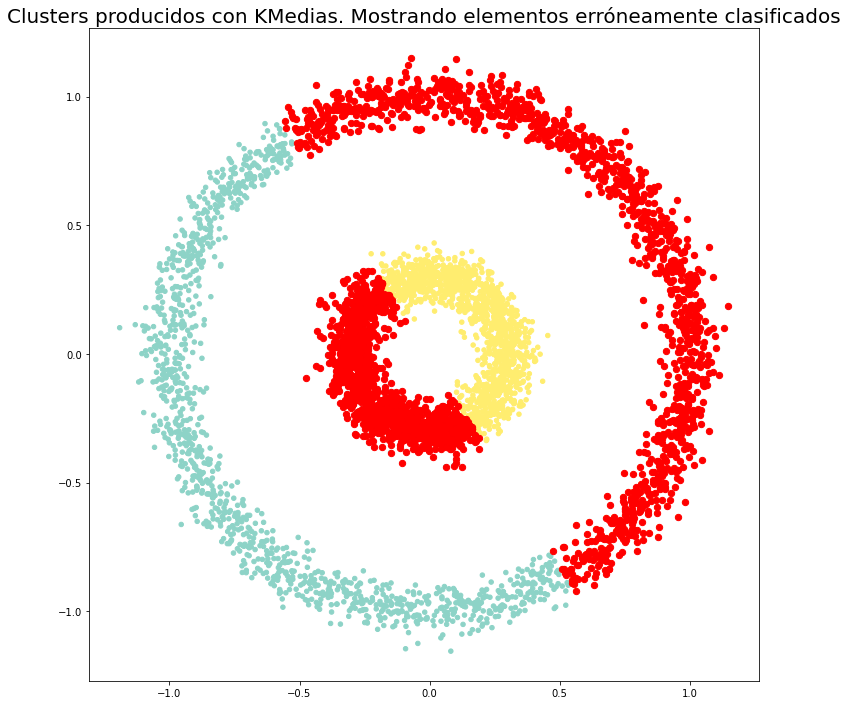

In [20]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
#SE GRAFICA DONDE SE EQUIVOCO EL KMEDIAS
plt.figure()
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")
plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20);

In [21]:
#SE IMPRIMEN LAS METRICAS
print("Metricas para circulares con KMEANS")
print("La silueta: ",silhouette_score(X, etiquetas_kmedias))
print("[H,C,Medida_V]",homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias))

Metricas para circulares con KMEANS
La silueta:  0.2965424749380652
[H,C,Medida_V] (7.804653220474846e-05, 7.806397607991157e-05, 7.805525316773585e-05)


**DBSCAN**

In [22]:
#AHORA SE UTILIZA DBSCAN
estimador_dbscan = DBSCAN(eps=0.05, min_samples=10)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_
np.unique(etiquetas_dbscan)

array([-1,  0,  1], dtype=int64)

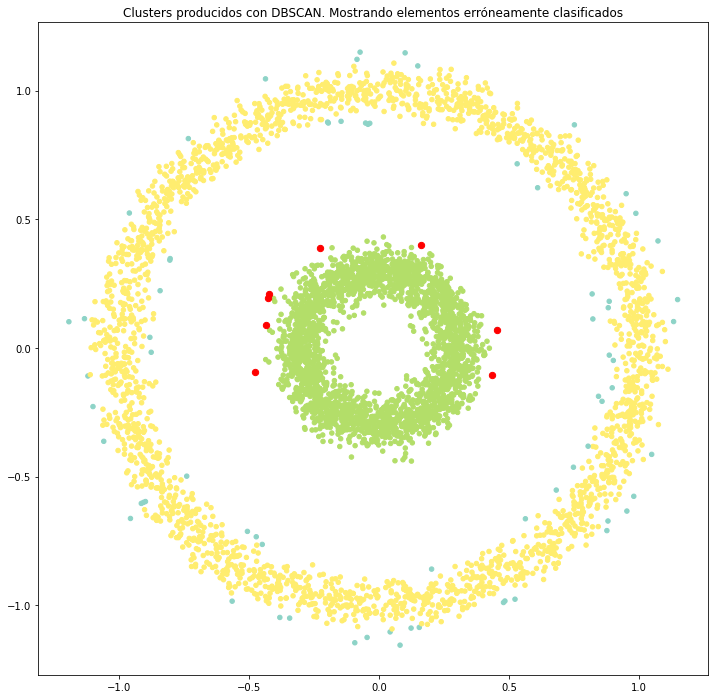

In [23]:
#SE OBSERVA LA CLASIFICACION POR DBSCAN
plt.figure()
plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")
plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

In [24]:
#SE IMPRIMEN LAS METRICAS
print("Metricas con DBSCAN para circulares")
print("Silueta: ",silhouette_score(X, etiquetas_dbscan))
print(homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan))

Metricas con DBSCAN para circulares
Silueta:  0.19928594442477718
(0.9925576876229771, 0.9021177335794555, 0.9451791917341158)


En este caso he obtenido los hiperparámetros eps=0.05, min_samples=10 a ojo, iterando sobre el gráfico para ver que valores separaban correctamente las clases reales.

En general haríamos una optimización de hiperparámetros para obtener los valores que mejor funcionen.

Una desventaja del estimador DBSCAN en ´sklearn´ es que no tiene el método predict. Es decir, no puede asignar clusters a nuevos puntos sin tener que ajustar el estimador desde cero.

**EL PREDICT EN LOS METODOS DE CLUSTERING SOLO ES PARA EVALUAR TU PROPUESTA**